In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
from decimal import *

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sys.path.append('../../qerr')

from dgnss_utils import panoseti_file_interfaces as pfi
from dgnss_utils import pff
from qerr_utils import *

In [2]:
def load_ph_data(data_dir, run_dir, module_id):
    ori = pfi.ObservingRunInterface(data_dir, run_dir)
    if module_id not in ori.obs_pff_files:
        print(f'No module with ID "{module_id}"\n'
              f'Available module_ids:\n\t{list(ori.obs_pff_files.keys())}')
        return
    columns = [
        'wr_timestamp (s)',
        'date',
        'quabo_num',
        'pkt_num',
        'pkt_tai',
        'pkt_nsec',
        'tv_sec',
        'tv_usec',
        # 'img_data'
    ]
    ph_df = pd.DataFrame(columns=columns)
    
    for ph_file in ori.obs_pff_files[module_id]["ph"]:
        fname = ph_file["fname"]
        fpath = f'{data_dir}/{run_dir}/{fname}'
        with open(fpath, 'rb') as fp:
            frame_iterator = ori.pulse_height_frame_iterator(fp, 1)
            for j, img in frame_iterator:
                j['wr_timestamp (s)'] = pff.wr_to_unix_decimal(j['pkt_tai'], j['pkt_nsec'], j['tv_sec'])
                # j['img_data'] = img
                ph_df.loc[len(ph_df)] = j
    ph_df['unix_timestamp'] = pd.to_datetime(ph_df['wr_timestamp (s)'].astype(np.float64), unit = 's', utc=True)
    ph_df = ph_df.sort_values(by='wr_timestamp (s)')
    return ph_df

def load_qerr_df(merged_fpath):
    df = load_data(merged_fpath)
    df['unix_timestamp'] = pd.to_datetime(df['pkt_unix_timestamp_TIM-TP'], unit='ns')
    # qerr data timestamps are in pacific time
    df['unix_timestamp'] = df['unix_timestamp'].dt.tz_localize('US/Pacific').dt.tz_convert('utc')
    df['qErr (ns)'] = df['qErr (ps)'] * 1e-3
    df = df.sort_values(by='unix_timestamp')
    return df

def align_data(q0, qerr0, q1, qerr1):
    """
    Returns 1PPS quabo and qerr data to their earliest common timestamp and latest common timestamp. 
    """
    tsts = {
        'q0': q0,
        'qerr0': qerr0,
        'q1': q1,
        'qerr1': qerr1,
    } 
    ealiest_common_timestamp = max(map(lambda s: s['unix_timestamp'].round('ms').min(), tsts.values()))
    latest_common_timestamp = min(map(lambda s: s['unix_timestamp'].round('ms').max(), tsts.values()))

    def trim(df):
        start_idx = np.searchsorted(df['unix_timestamp'], ealiest_common_timestamp, side='right')
        end_idx = np.searchsorted(df['unix_timestamp'], latest_common_timestamp, side='left')
        return df.iloc[start_idx:end_idx].reset_index(drop=True)
        
    aq0, aqerr0, aq1, aqerr1 = trim(q0), trim(qerr0), trim(q1), trim(qerr1)
    new_len = min(len(aq0), len(aqerr0), len(aq1), len(aqerr1))
    return aq0[:new_len], aqerr0[:new_len], aq1[:new_len], aqerr1[:new_len]

In [3]:
data_dir = '../data'
run_dir = 'obs_UCB_lab.start_2024-07-08T20:15:59Z.runtype_eng-test.pffd'

qerr0_fpath = '../../qerr/data/quabo_qerr_data/data/start_2024-07-08T13:15:47.088459.device_ttyUSB0/data-type_MERGED.start_2024-07-08T13:15:47.088459'
qerr1_fpath = '../../qerr/data/quabo_qerr_data/data/start_2024-07-08T13:15:53.105972.device_ttyUSB1/data-type_MERGED.start_2024-07-08T13:15:53.105972'
pfi.ObservingRunInterface(data_dir, run_dir).obs_pff_files

{253: {'img': [],
  'ph': [{'fname': 'start_2024-07-08T20:16:07Z.dp_ph256.bpp_2.module_253.seqno_0.pff',
    'seqno': 0,
    'nframes': 3991,
    'first_unix_t': Decimal('1720469773.954754725'),
    'last_unix_t': Decimal('1720473763.954754713')}]},
 254: {'img': [],
  'ph': [{'fname': 'start_2024-07-08T20:16:07Z.dp_ph256.bpp_2.module_254.seqno_0.pff',
    'seqno': 0,
    'nframes': 3991,
    'first_unix_t': Decimal('1720469773.95475466'),
    'last_unix_t': Decimal('1720473763.954754644')}]}}

In [4]:
qerr0 = load_qerr_df(qerr0_fpath)
q0 = load_ph_data(data_dir, run_dir, 253)

qerr1 = load_qerr_df(qerr1_fpath)
q1 = load_ph_data(data_dir, run_dir, 254)

In [5]:
# Align data
aq0, aqerr0, aq1, aqerr1 = align_data(q0, qerr0, q1, qerr1)

for df in [aq0, aqerr0, aq1, aqerr1]:
    # print(len(df))
    # print(df['unix_timestamp'].iloc[0].round('ms'))
    print(df['unix_timestamp'].iloc[-1].round('ms'))

# Compute differences
diffs = pd.DataFrame(columns=['quabo_wr_diffs', 'qerr_diffs', 'quabo_wr_diffs_without_qerrs'])

diffs['quabo_wr_diffs (ns)'] = ((aq0['wr_timestamp (s)'] - aq1['wr_timestamp (s)']) * 10**9).astype(np.float64)  # Do second -> nanosecond conversion with Decimal to elimiate floating-point errors
diffs['qerr_diffs (ns)'] = (aqerr1['qErr (ns)'] - aqerr0['qErr (ns)'])
diffs['quabo_wr_diffs_without_qerrs (ns)'] = diffs['quabo_wr_diffs (ns)'] - diffs['qerr_diffs (ns)']

print()
print(diffs.describe())

2024-07-08 21:22:34.955000+00:00
2024-07-08 21:22:34.063000+00:00
2024-07-08 21:22:34.955000+00:00
2024-07-08 21:22:34.071000+00:00

       quabo_wr_diffs (ns)  qerr_diffs (ns)  quabo_wr_diffs_without_qerrs (ns)
count          3981.000000      3981.000000                        3981.000000
mean             66.320522         0.098218                          66.222304
std               3.224709         3.142451                           0.727136
min              58.000000        -7.565000                          64.083000
25%              64.000000        -2.124000                          65.703000
50%              66.000000         0.130000                          66.178000
75%              69.000000         2.371000                          66.688000
max              75.000000         7.598000                          68.642000


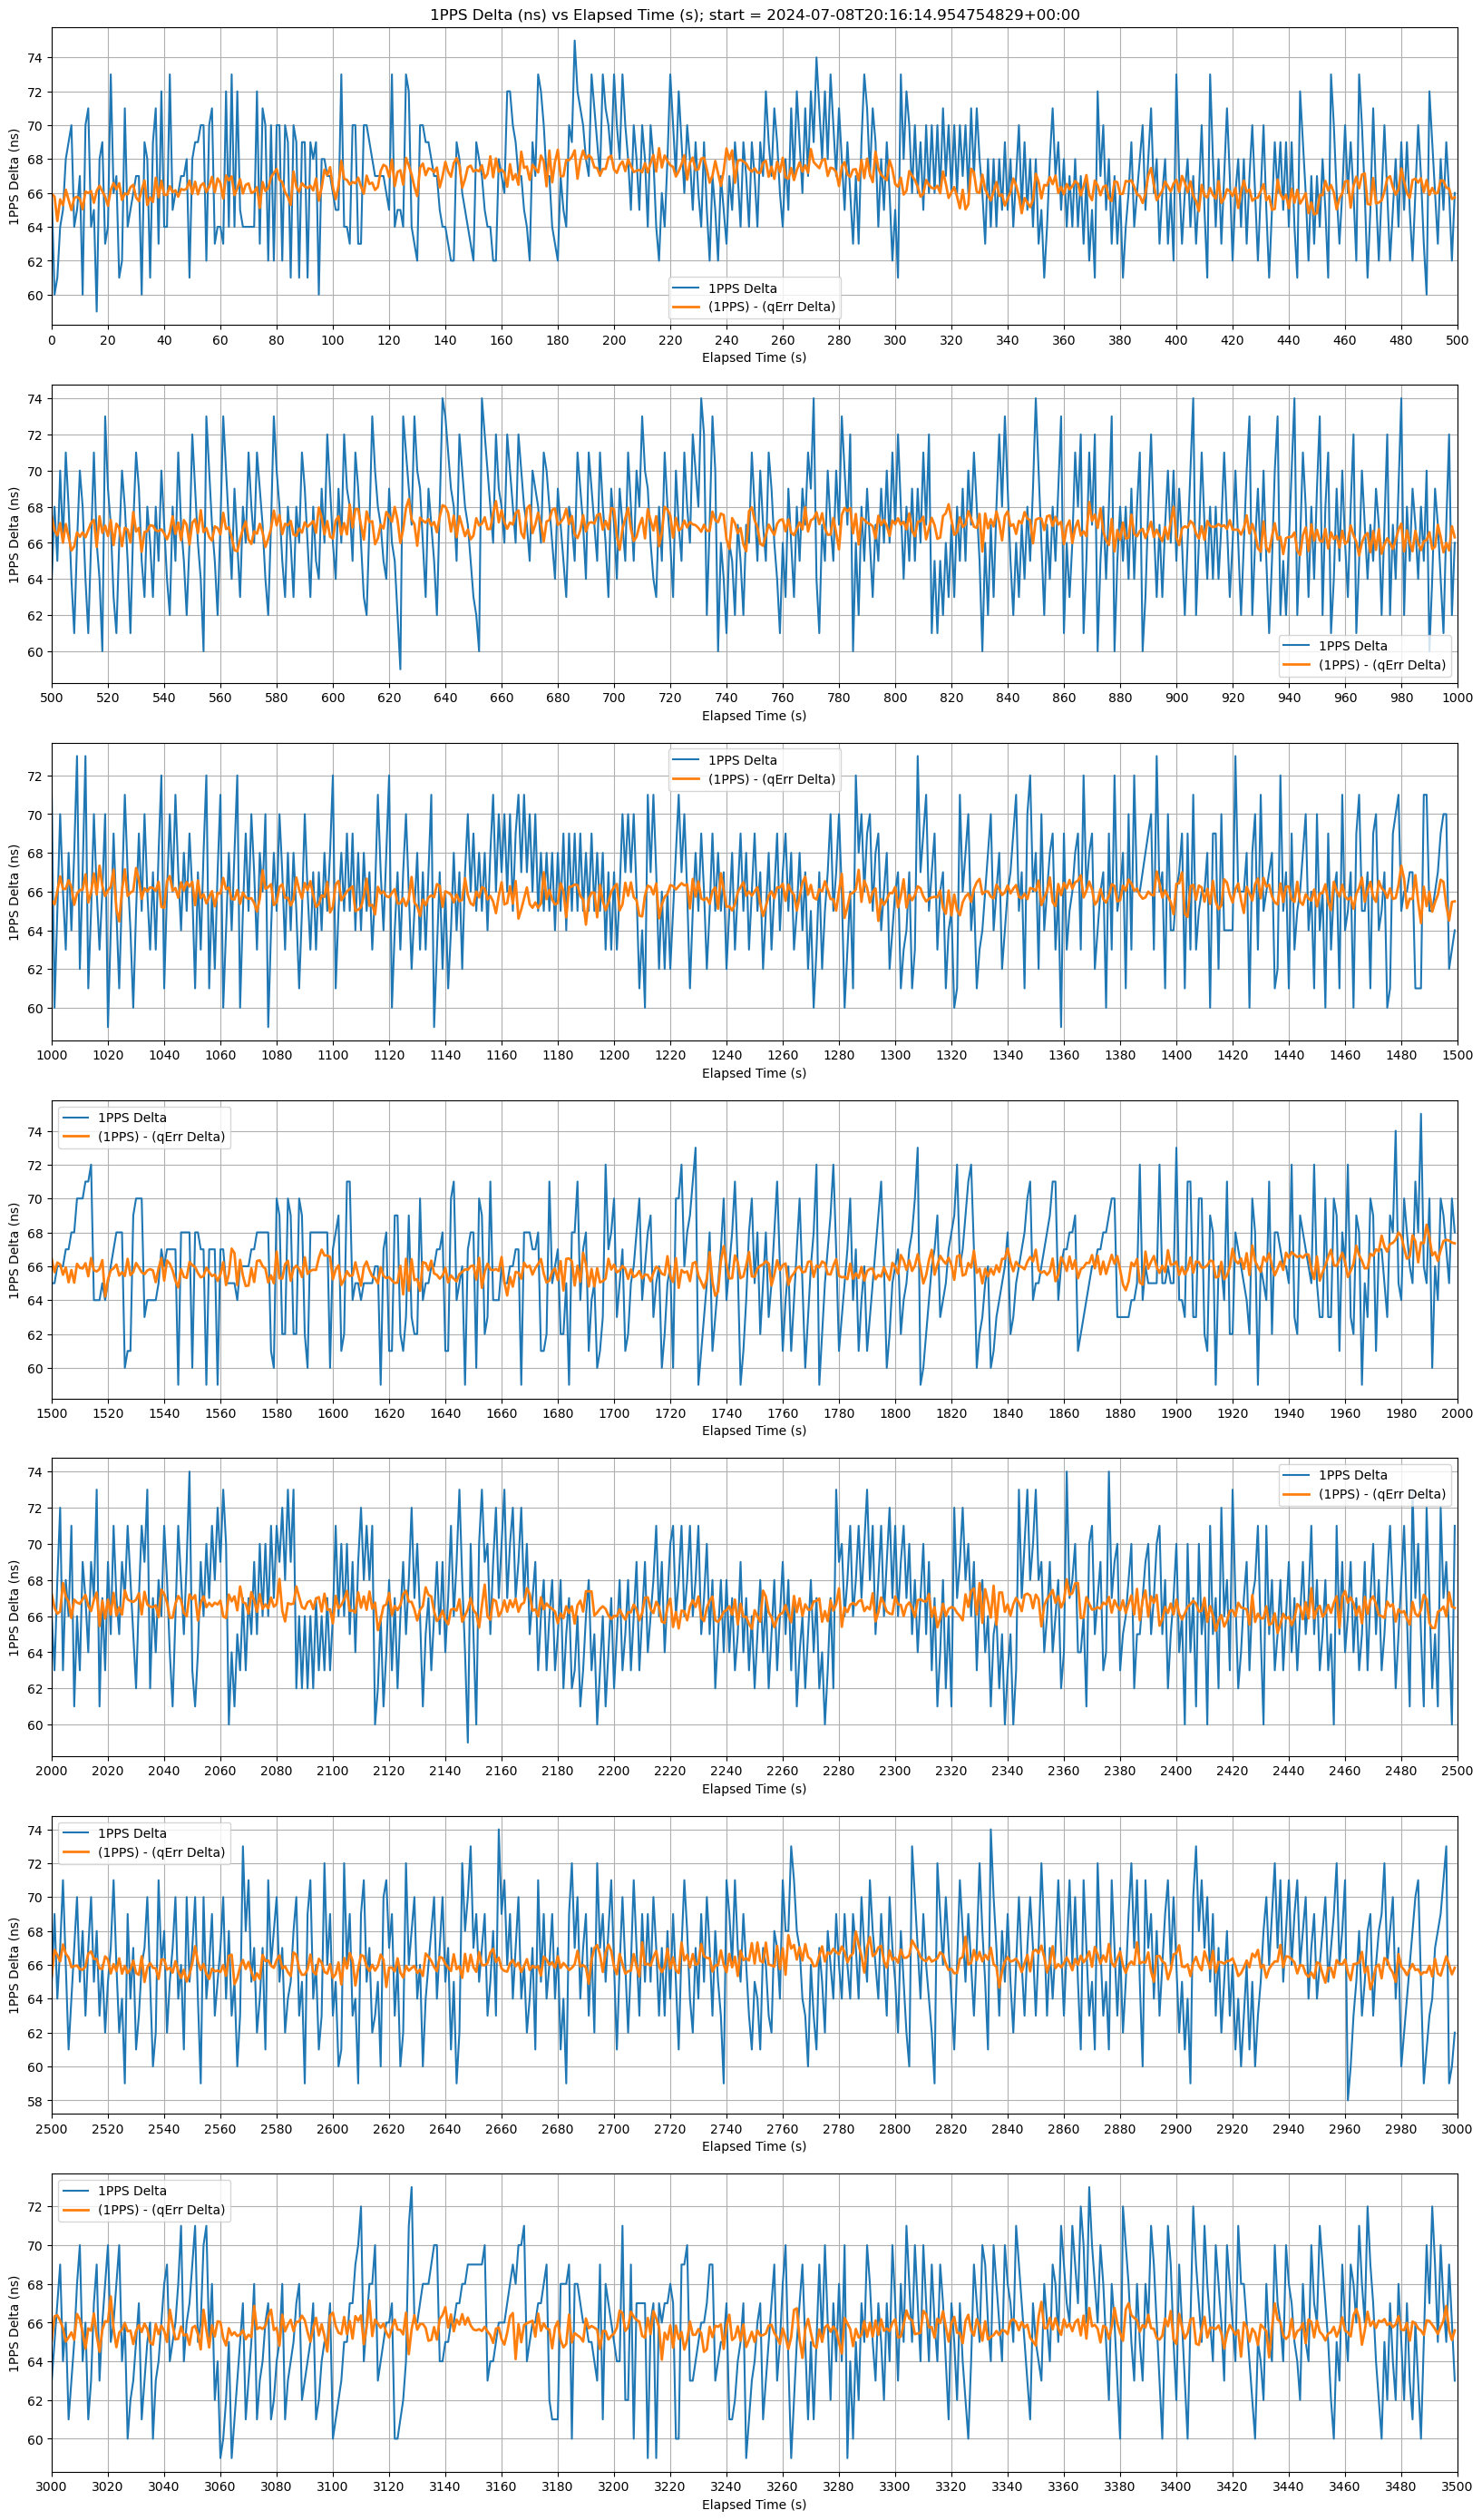

In [16]:
# Create plot
start_timestamp = aq0['unix_timestamp'][0].isoformat()

total_time = len(aq0)
time_per_window = 500
nsubplots = total_time // time_per_window

plot_qerr = False

xtick_spacing = 20
ax_height = 5
ax_width = 20

f, axs = plt.subplots(nsubplots, 1, figsize=(ax_width, ax_height * nsubplots))

for i in range(nsubplots):
    t_low = time_per_window * i
    t_high = time_per_window * (i + 1)
    diffs_in_window = diffs[t_low: t_high]
    
    if nsubplots > 1:
        ax = axs[i]
    else:
        ax = axs
    
    sns.lineplot(
        diffs_in_window['quabo_wr_diffs (ns)'], 
        label='1PPS Delta', 
        ax=ax
    )
    sns.lineplot(
        diffs_in_window['quabo_wr_diffs_without_qerrs (ns)'],
        label='(1PPS) - (qErr Delta)',
        ax=ax,
        linewidth = 2
    )
    if plot_qerr:
        sns.lineplot(
            diffs_in_window['qerr_diffs (ns)'],
            label='qErr Delta',
            ax=ax
        )

    # Style axis
    
    ax.set_xlabel('Elapsed Time (s)')
    if xtick_spacing:
        ax.set_xticks(np.arange(t_low, t_high + xtick_spacing, xtick_spacing))
    ax.set_xlim([t_low, t_high])
    
    ax.set_ylabel('1PPS Delta (ns)')
    # ax.set_yticks(np.arange(-7.5, 27.5, 2.5))
    
    ax.grid(True)
    
    
    if i == 0:
        ax.set_title(f'1PPS Delta (ns) vs Elapsed Time (s); start = {start_timestamp}')
    # else:
    #     ax.get_legend().remove();
    

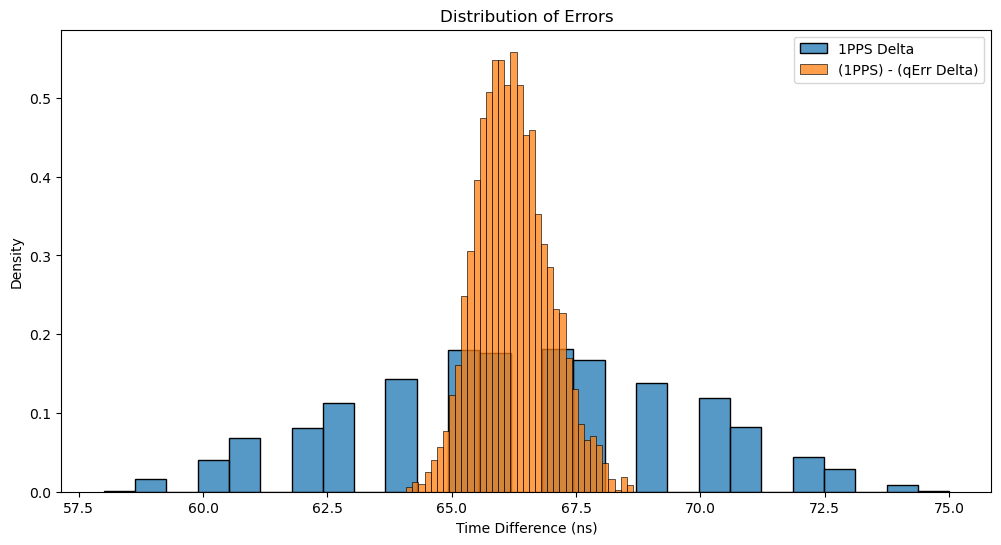

In [11]:
plt.figure(figsize=(12,6))
# plt.grid(True)
sns.histplot(diffs['quabo_wr_diffs (ns)'], stat='density', label='1PPS Delta', common_bins=False);
sns.histplot(diffs['quabo_wr_diffs_without_qerrs (ns)'], stat='density', label='(1PPS) - (qErr Delta)');

plt.legend()
# plt.axvline(x=np.mean(data), label='mean', c='r')
# plt.axvline(x=np.median(data), label='median', c='b')
plt.title('Distribution of Errors')
plt.xlabel('Time Difference (ns)');
